# Chapter 3 : Versioning large datasets with DVC

In the previous chapter, we saw how to install and use [DVC](https://dvc.org) to version code and data in a simple way. However, our input dataset was extremely simple and could have been versionned with [Git](https://git-scm.com) without difficulty.

The main objective of this second chapter is to show the true power of [DVC](https://dvc.org).

We will keep our objective of predicting [Alzheimer's disease](https://en.wikipedia.org/wiki/Alzheimer%27s_disease) (AD) vs Control subjects, but instead of assuming a simple preprocessed dataset with the [hippocampus](https://en.wikipedia.org/wiki/Hippocampus) volumes already computed, we will work directly with brain images and train a deep learning model to perform this task.

This chapter also aims at showing some more advanced features of [DVC](https://dvc.org) like [data pipelines](https://dvc.org/doc/start/data-management/data-pipelines).

We will define our experiment as a pipeline using [DVC](https://dvc.org) commands, and see how easily we can reproduce past experiments with this infrastructure.

Let's dive in !

## Install dependencies

`````{admonition} Virtual environments
:class: tip

We strongly encourage you to create a virtual environment specifically for this tutorial.
If you haven't done it already and if you are using conda, you can do the following:

```bash
$ conda create --name now python=3.10
$ conda activate now
```

`````

In order to focus on the code and data management side of things, we abstracted as much code as possible. To do so, we created a very small Python library called `now_2023` that we will use in order to plot brain images, train deep learning models, and save results. We can install this library with pip:

In [ ]:
# Dirty for now...
! pip install git+https://github.com/aramis-lab/NOW-2023-lib.git/

In [ ]:
# If you are running on collab or if you don't have tree installed:
# ! apt-get install tree

In [ ]:
! pip install dvc

## Setup the repo

Since this is a new notebook meant to be independant from the notebooks of the first chapters, we will start a new project from scratch.

Start by configuring the [Git](https://git-scm.com) and [DVC](https://dvc.org) repo:

In [1]:
! git init
! dvc init

Initialized empty Git repository in /Users/nicolas.gensollen/GitRepos/NOW-2023/notebooks/.git/
Initialized DVC repository.

You can now commit the changes to git.

+---------------------------------------------------------------------+
|                                                                     |
|        DVC has enabled anonymous aggregate usage analytics.         |
|     Read the analytics documentation (and how to opt-out) here:     |
|             <https://dvc.org/doc/user-guide/analytics>              |
|                                                                     |
+---------------------------------------------------------------------+

What's next?
------------
- Check out the documentation: <https://dvc.org/doc>
- Get help and share ideas: <https://dvc.org/chat>
- Star us on GitHub: <https://github.com/iterative/dvc>


As with the previous notebook, you might need to configure your username and email:

In [2]:
! git config --local user.email "john.doe@inria.fr"
! git config --local user.name "John Doe"
! git commit -m "initialize DVC"

[main (root-commit) 062acd4] initialize DVC
 3 files changed, 6 insertions(+)
 create mode 100644 .dvc/.gitignore
 create mode 100644 .dvc/config
 create mode 100644 .dvcignore


```{note}
Throughout this tutorial, we will write things to files. Usually, you would do this using your favorite IDE. However, we need this tutorial to be runnable as a notebook (for example for the attendees running it on Collab). Because of this, we will be using IPython magic commands `%%writefile` and `%run` in order to write to a file the content of a cell, and run a given python script.

If you are following locally, you can of course edit the different files directly !
```

Let's add some patterns to the [.gitignore](https://git-scm.com/docs/gitignore) file in order to not display IPython notebooks related files when doing a [git status](https://git-scm.com/docs/git-status):

In [3]:
%%writefile -a .gitignore

*.ipynb
__pycache__
.DS_Store
.ipynb_checkpoints

Writing .gitignore


## Getting the input dataset

In this session we use the images from a public research project: [OASIS-1](https://www.oasis-brains.org). Two labels exist in this dataset:

- CN (Cognitively Normal) for healthy participants.
- AD (Alzheimer’s Disease) for patients affected by [Alzheimer's disease](https://en.wikipedia.org/wiki/Alzheimer%27s_disease).

The original images were preprocessed using [Clinica](https://www.clinica.run): a software platform for clinical neuroimaging studies.

Preprocessed images and other files are distributed in a tarball, if you haven't downloaded the images before the tutorial, run the following commands to download and extract them:

In [4]:
# Only run if necessary !
#
# ! wget --no-check-certificate --show-progress https://aramislab.paris.inria.fr/files/data/databases/DL4MI/OASIS-1-dataset_pt_new.tar.gz
# ! tar -xzf OASIS-1-dataset_pt_new.tar.gz

## Write a Python script to run the experiment

Let's start writing a Python file which will contain the code required to run our experiment. Our objective is to be able to run

```
$ python run_experiment.py
```

from the command-line to run the full experiment.

Let's start by defining the path to the raw dataset folder we just downloaded. If you run the cell above, it should be `./OASIS-1_dataset`. If you downloaded the data before the workshop, it is probably somewhere else on your machine.

In [5]:
%%writefile -a run_experiment.py 

from pathlib import Path

# oasis_folder = Path("./OASIS-1_dataset/")
oasis_folder = Path("/Users/nicolas.gensollen/NOW_2023/OASIS-1_dataset/")

Writing run_experiment.py


Executing the previous cell wrote its content to our file, let's also execute this file to have the declared imports and variables in this Python session:

In [6]:
%run run_experiment.py

In [7]:
print([file.name for file in oasis_folder.iterdir()])

['CAPS', 'README.md', 'tsv_files', 'raw']


The raw dataset contains:

- a `tsv_files` folder in which we have metadata relative to the different subjects
- a `README.md` file giving some information on the dataset
- a `CAPS` folder holding the preprocessed brain images
- a `raw` folder holding the raw brain images

At the same time, we will write a second Python file `prepare_train_validation_sets.py` which will be responsible for splitting our list of subjects into a training set and a validation set. This is important because we will compute validation metrics once our model has been trained:

In [8]:
%%writefile -a prepare_train_validation_sets.py

import pandas as pd
from pathlib import Path

# oasis_folder = Path("./OASIS-1_dataset/")
oasis_folder = Path("/Users/nicolas.gensollen/NOW_2023/OASIS-1_dataset/")

columns_to_use = [
    "participant_id",
    "session_id",
    "alternative_id_1",
    "sex",
    "education_level",
    "age_bl",
    "diagnosis_bl",
    "laterality",
    "MMS",
    "cdr_global",
    "diagnosis",
]

OASIS_df = pd.read_csv(
    oasis_folder / "tsv_files" / "lab_1" / "OASIS_BIDS.tsv",
    sep="\t",
    usecols=columns_to_use,
)

Writing prepare_train_validation_sets.py


In [9]:
%run prepare_train_validation_sets.py

Let's take a look at some statistics in order to better understand our data:

   participant_id session_id alternative_id_1 sex  education_level  age_bl  \
0  sub-OASIS10001    ses-M00    OAS1_0001_MR1   F              2.0      74   
1  sub-OASIS10002    ses-M00    OAS1_0002_MR1   F              4.0      55   
2  sub-OASIS10003    ses-M00    OAS1_0003_MR1   F              4.0      73   
3  sub-OASIS10004    ses-M00    OAS1_0004_MR1   M              NaN      28   
4  sub-OASIS10005    ses-M00    OAS1_0005_MR1   M              NaN      18   

  diagnosis_bl laterality   MMS  cdr_global diagnosis  
0           CN          R  29.0         0.0        CN  
1           CN          R  29.0         0.0        CN  
2           AD          R  27.0         0.5        AD  
3           CN          R  30.0         NaN        CN  
4           CN          R  30.0         NaN        CN  


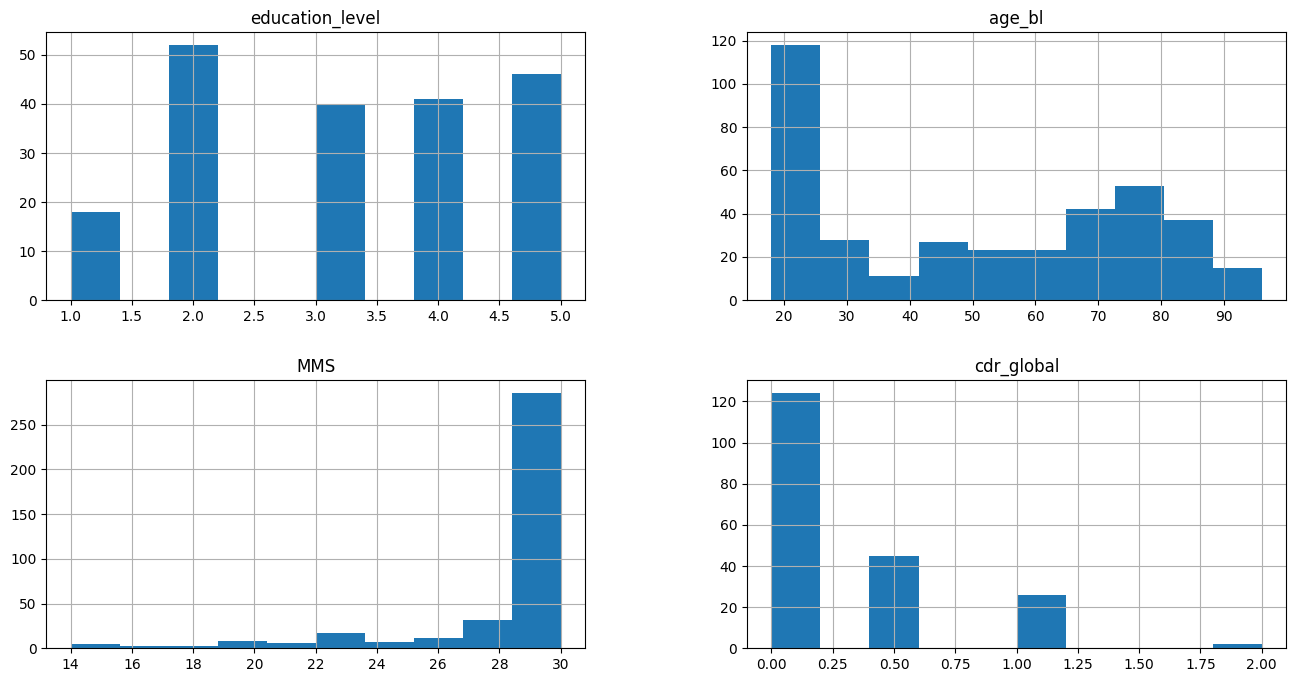

In [10]:
print(OASIS_df.head())

_ = OASIS_df.hist(figsize=(16, 8))

From these graphics, it’s possible to have an overview of the distribution of the data, for the numerical values. For example, the educational level is well distributed among the participants of the study. Also, most of the subjects are young (around 20 years old) and healthy (MMS score equals 30 and null CDR score).

In [11]:
from now_2023.utils import characteristics_table

population_df = characteristics_table(OASIS_df, OASIS_df)
population_df

,N,age,%sexF,education,MMS,CDR=0,CDR=0.5,CDR=1,CDR=2
AD,73,77.5 ± 7.4,63.0,2.7 ± 1.3,22.7 ± 3.6,0,45,26,2
CN,304,44.0 ± 23.3,62.2,3.5 ± 1.2,29.7 ± 0.6,124,0,0,0


## Preprocessing

Theoretically, the main advantage of deep learning methods is to be able to work without extensive data preprocessing. However, as we have only a few images to train the network in this lab session, the preprocessing here is very extensive. More specifically, the images encountered:

- Non-linear registration.
- Segmentation of grey matter.
- Conversion to tensor format (.pt).

As mentioned above, to obtain the preprocessed images, we used some pipelines provided by [Clinica](https://www.clinica.run) and [ClinicaDL](https://clinicadl.readthedocs.io/en/latest/) in order to:

- Convert the original dataset to [BIDS](https://bids-specification.readthedocs.io/en/stable/) format ([clinica convert oasis-2-bids](https://aramislab.paris.inria.fr/docs/public/latest/Converters/OASIS2BIDS/)).
- Get the non-linear registration and segmentation of grey mater (pipeline [t1-volume](https://aramislab.paris.inria.fr/docs/public/latest/Pipelines/T1_Volume/)).
- Obtain the preprocessed images in tensor format ([tensor extraction using ClinicaDL, clinicadl extract](https://clinicadl.readthedocs.io/en/stable/Preprocessing/Extract/)).
- The preprocessed images are store in the [CAPS folder structure](http://www.clinica.run/doc/CAPS/Introduction/) and all have the same size (121x145x121).

To facilitate the training and avoid overfitting due to the limited amount of data, the model won’t use the full image but only a part of the image (size 30x40x30) centered on a specific neuroanatomical region: the [hippocampus](https://en.wikipedia.org/wiki/Hippocampus) (HC). This structure is known to be linked to memory, and is atrophied in the majority of cases of Alzheimer’s disease patients.

Before going further, let's take a look at the images we have downloaded and let's compute a cropped image of the left HC for a randomly selected subject:

In [12]:
import torch
from now_2023.plotting import plot_image, plot_tensor
from now_2023.utils import CropLeftHC

# Select a random subject
subject = 'sub-OASIS10003'

# The path to the hc image
image_folder = (
    oasis_folder /
    "CAPS" /
    "subjects" /
    subject /
    "ses-M00" /
    "deeplearning_prepare_data" /
    "image_based" /
    "custom"
)

# The image file name as a specific structure
image_filename = f"{subject}_ses-M00_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability.pt"
preprocessed_pt = torch.load(image_folder / image_filename)

You can use the `plot_image()` and `plot_tensor()` functions from the `now_2023` library to visualize these images. Do not hesitate to play with the `cut_coords` argument to view different slices:

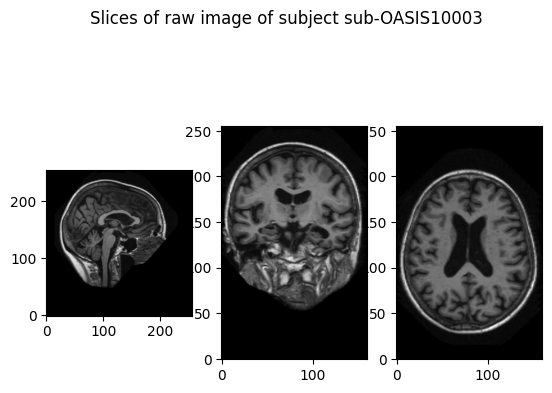

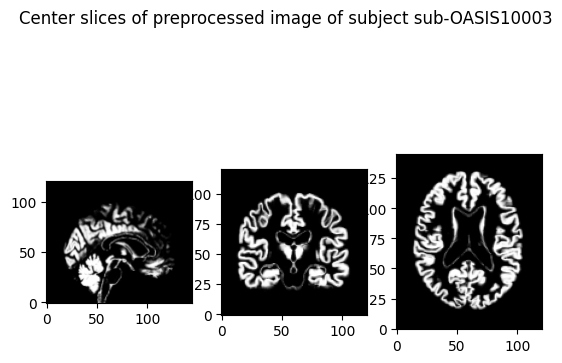

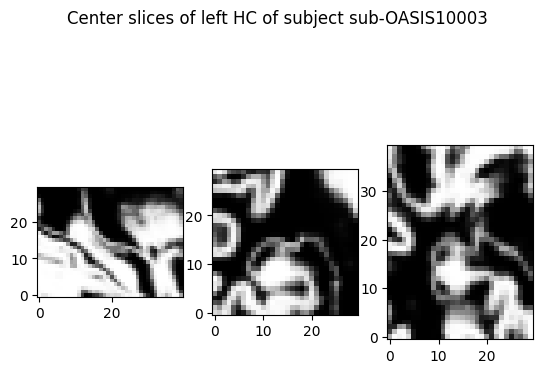

In [13]:
plot_image(
    oasis_folder / "raw" / f"{subject}_ses-M00_T1w.nii.gz",
    cut_coords=(78, 122, 173),
    title=f'Slices of raw image of subject {subject}',
)
plot_tensor(
    preprocessed_pt,
    cut_coords=(60, 72, 60),
    title=f'Center slices of preprocessed image of subject {subject}',
)
plot_tensor(
    CropLeftHC()(preprocessed_pt),
    cut_coords=(15, 20, 15),
    title=f'Center slices of left HC of subject {subject}',
)

## Use only the left HC

We are going to generate a new dataset consisting only of images of the left [hippocampus](https://en.wikipedia.org/wiki/Hippocampus). Our dataset will basically consist of images like the last image above. 

For simplicity, this is the dataset that we will consider as our input dataset, just like we pretended that the TSV file with the HC volumes computed was our input dataset in the previous chapter. This also means that the dataset we are about to generate will be the one we will version.

```{note}
Note that there is nothing preventing us to version the raw dataset. We are doing this because we will pretend to receive a data update later on consisting of the right HC images.
```

Note also that to improve the training and reduce overfitting, we can add a random shift to the cropping function. This means that the bounding box around the [hippocampus](https://en.wikipedia.org/wiki/Hippocampus) may be shifted by a limited amount of voxels in each of the three directions.

Let's generate our dataset:

In [14]:
from now_2023.data_generation import generate_cropped_hc_dataset

data_folder = Path("./data")

generate_cropped_hc_dataset(
    oasis_folder,
    hemi="left",
    output_folder=data_folder,
    verbose=False,
)

This should have created a new `data` folder in the current workspace, which should have the following structure:

In [15]:
! tree data | head -n 14

data
└── subjects
    ├── sub-OASIS10001
    │   └── ses-M00
    │       └── deeplearning_prepare_data
    │           └── image_based
    │               └── custom
    │                   └── sub-OASIS10001_ses-M00_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability_left.pt
    ├── sub-OASIS10002
    │   └── ses-M00
    │       └── deeplearning_prepare_data
    │           └── image_based
    │               └── custom
    │                   └── sub-OASIS10002_ses-M00_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability_left.pt


As you can see, we have one tensor image for each subject, representing the extracted left hippocampus.

Let's take a look at some of these images. To do so, you can use the `plot_hc()` function from the `now_2023` library which is a wrapper around the `plot_tensor()` function you used before. Again, feel free to play with the parameters to view different slices or different subjects: 

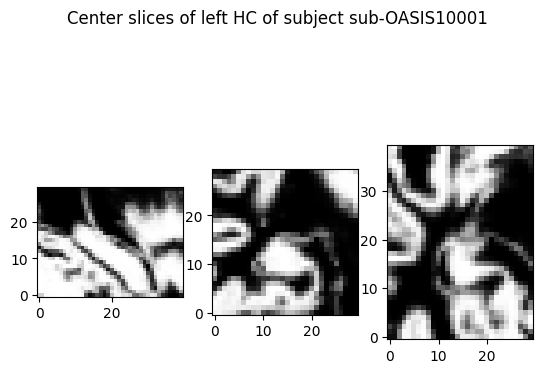

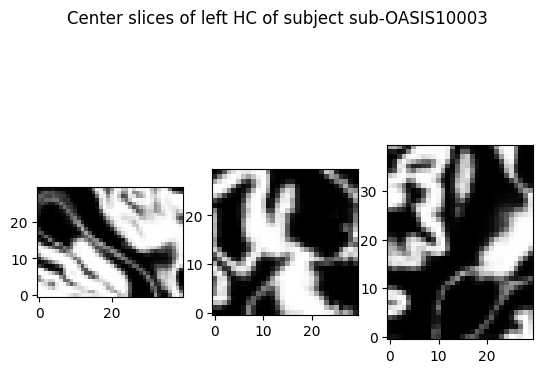

In [16]:
from now_2023.plotting import plot_hc

plot_hc(data_folder, 'sub-OASIS10001', "left", cut_coords=(15, 20, 15))
plot_hc(data_folder, 'sub-OASIS10003', "left", cut_coords=(10, 30, 25))

### Cross-validation

In order to choose hyperparameters the set of images is divided into a training set (80%) and a validation set (20%). The data split was performed in order to ensure a similar distribution of diagnosis, age and sex between the subjects of the training set and the subjects of the validation set. Moreover the MMS distribution of each class is preserved.

In [17]:
%%writefile -a prepare_train_validation_sets.py

from now_2023.utils import characteristics_table

train_df = pd.read_csv(oasis_folder / "tsv_files" / "lab_1" / "train.tsv", sep="\t")
valid_df = pd.read_csv(oasis_folder / "tsv_files" / "lab_1" / "validation.tsv", sep="\t")

train_df["hemi"] = "left"
valid_df["hemi"] = "left"

train_population_df = characteristics_table(train_df, OASIS_df)
valid_population_df = characteristics_table(valid_df, OASIS_df)

print("*" * 50)
print(f"Train dataset:\n {train_population_df}\n")
print("*" * 50)
print(f"Validation dataset:\n {valid_population_df}")
print("*" * 50)

train_df.to_csv("train.csv")
valid_df.to_csv("validation.csv")

Appending to prepare_train_validation_sets.py


At this point, the step of our experiment consisting of preparing the training and validation sets is complete. We could simply run 

```bash
python prepare_train_validation_sets.py
```

but we are going to see another way to do that. Instead of just running this command, we are going to use [DVC](https://dvc.org) to codify our first experimental step. To do that, we will rely on the [dvc stage](https://dvc.org/doc/command-reference/stage) comand which is a bit more complicated than the previous [DVC](https://dvc.org) commands we saw before:

In [18]:
! dvc stage add -n prepare_train_validation \
  -d prepare_train_validation_sets.py -d data \
  -o train.csv -o validation.csv \
  python prepare_train_validation_sets.py

Added stage 'prepare_train_validation' in 'dvc.yaml'                  core>

To track the changes with git, run:

	git add dvc.yaml .gitignore

To enable auto staging, run:

	dvc config core.autostage true


Let's take a closer look at this long command:

- The `-n` option enables us to give a name to this step. In our case, we named it "prepare_train_validation".
- The `-d` option enables us to declare dependencies, that is things on which this step depends. In our case, the step depends on the input data (the `data` folder), and the python file itself (`prepare_train_validation_sets.py`).
- The `-o` option enables ut to declare outputs, that is things that are produced by this step. In our case, the step produces two CSV files (`train.csv` and `validation.csv`)
- The final part of the command tells [DVC](https://dvc.org) the command it should run to perform this step. In our case, it needs to run `python prepare_train_validation_sets.py` to run the Python script.

OK, great, but what did this command actually do ?

As you can see from its output, it generated a `dvc.yaml` file which encode our experiment stage as well as its dependencies. Let's have a look at it:

In [19]:
! cat dvc.yaml

stages:
  prepare_train_validation:
    cmd: python prepare_train_validation_sets.py
    deps:
    - data
    - prepare_train_validation_sets.py
    outs:
    - train.csv
    - validation.csv


As you can see, it is pretty easy to read and understand. However, [dvc stage](https://dvc.org/doc/command-reference/stage) didn't run anything, it just generated this file. To run our first step, we can use the [dvc repro](https://dvc.org/doc/command-reference/repro) command:

In [20]:
! dvc repro

Running stage 'prepare_train_validation':                                       
> python prepare_train_validation_sets.py
**************************************************
Train dataset:
       N          age %sexF  education         MMS CDR=0 CDR=0.5 CDR=1 CDR=2
AD   58   77.4 ± 7.5  69.0  2.8 ± 1.4  22.6 ± 3.6     0      37    19     2
CN  242  43.4 ± 23.5  62.0  3.6 ± 1.2  29.8 ± 0.5    97       0     0     0

**************************************************
Validation dataset:
      N          age %sexF  education         MMS CDR=0 CDR=0.5 CDR=1 CDR=2
AD  15   78.2 ± 6.6  40.0  2.5 ± 1.0  22.9 ± 3.6     0       8     7     0
CN  62  46.3 ± 22.6  62.9  3.4 ± 1.3  29.6 ± 0.7    27       0     0     0
**************************************************
Generating lock file 'dvc.lock'                                                 
Updating lock file 'dvc.lock'

To track the changes with git, run:

	git add dvc.lock

To enable auto staging, run:

	dvc config core.autostage true
Use

In the output of dvc repro we can see the output generated by our Python scripts as well as the output generated by [DVC](https://dvc.org). It looks like [DVC](https://dvc.org) generated a `dvc.lock` file:

In [21]:
! cat dvc.lock

schema: '2.0'
stages:
  prepare_train_validation:
    cmd: python prepare_train_validation_sets.py
    deps:
    - path: data
      hash: md5
      md5: 06e8427de6ee70dce36c032e360107e6.dir
      size: 60729344
      nfiles: 416
    - path: prepare_train_validation_sets.py
      hash: md5
      md5: c8015ec57c1b76bd7578e0e8e6a41422
      size: 1139
    outs:
    - path: train.csv
      hash: md5
      md5: a696d40de31a824be7f8376404da00df
      size: 10432
    - path: validation.csv
      hash: md5
      md5: aa08487b3f7ec7c367d9a4c1dba20158
      size: 2650


We won't go into the details here, but the main idea is that this lock file is what [DVC](https://dvc.org) uses to know whether it should re-run a given stage given the state of the current workspace. It basically does this by computing the hash values of the stage dependencies and outputs and comparing these values to the ones in this file. If there is at least one mismatch, then the stage should be run again, otherwise dvc will use the cached inputs and outputs.

Note that these new files (`dvc.yaml` and `dvc.lock`) are still very small files which size does not depend on the input data size. This means that we are totally fine versioning them with Git, and this is precisely what [DVC](https://dvc.org) is telling us to do here.

Let's add the data with dvc add (we still haven't done that...), and do the same with [Git](https://git-scm.com) for the files we have generated (`dvc.yaml`, `dvc.lock`, `data.dvc`), and modified (`.gitignore`):

In [22]:
! dvc add data
! git add dvc.yaml .gitignore dvc.lock data.dvc

⠋ Checking graph                                       core>
Adding...                                                                       
!
                                                                                
!
  0% Checking cache in '/Users/nicolas.gensollen/GitRepos/NOW-2023/notebooks/.dv
                                                                                
!
  0%|          |Adding data to cache                  0/? [00:00<?,     ?file/s]
  0%|          |Adding data to cache                0/416 [00:00<?,     ?file/s]
  0%|          |Adding data to cache                0/416 [00:00<?,     ?file/s]
 86%|████████▌ |Adding data to cache        358/416 [00:00<00:00, 3573.32file/s]
                                                                                
!
  0%|          |Checking out /Users/nicolas.gensollen/0/? [00:00<?,    ?files/s]
  0%|          |Checking out /Users/nicolas.gensolle0/417 [00:00<?,    ?files/s]
 43%|████▎     |Checking out /Users/nico

In [23]:
! git status

On branch main
Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	new file:   .gitignore
	new file:   data.dvc
	new file:   dvc.lock
	new file:   dvc.yaml

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	prepare_train_validation_sets.py
	run_experiment.py



In [24]:
! dvc dag

        +----------+         
        | data.dvc |         
        +----------+         
              *              
              *              
              *              
+--------------------------+ 
| prepare_train_validation | 
+--------------------------+ 


### Model

We propose here to design a convolutional neural network that takes for input a patch centered on the left hippocampus of size 30x40x30.

The architecture of the network was found using a Random Search on architecture + optimization hyperparameters.

Let's save the model and validation metrics:

Our model requires some hyper-parameters. Since the values of these hyper-parameters impact the results of our experiment, we will define them in a specific `params.yaml` file: 

In [21]:
%%writefile -a params.yaml

train:
    learning_rate: 0.0001
    n_epochs: 30
    batch_size: 4

Writing params.yaml


You can either define them all at the root, or organize them in a dict-like fashion. Here we have put all parameters inside a `train` section, but we could have defined them all at the root as well.

In [22]:
%%writefile -a run_experiment.py

import dvc.api
import json
import pandas as pd
from now_2023.models import CNNModel

data_folder = Path("./data")

train_df = pd.read_csv("train.csv")
valid_df = pd.read_csv("validation.csv")

params = dvc.api.params_show()
learning_rate = params['train']['learning_rate']
n_epochs = params['train']['n_epochs']
batch_size = params['train']['batch_size']

print("*" * 50)
model = CNNModel(
    learning_rate=learning_rate,
    n_epochs=n_epochs,
    batch_size=batch_size,
)
print(f"Fitting model on {len(train_df)} samples...")
model.fit(data_folder, train_df)

results_training_left, metrics_training_left = model.predict(data_folder, train_df)
results_validation_left, metrics_validation_left = model.predict(data_folder, valid_df)

print("*" * 50)
print(f"Metrics on training set :\n{json.dumps(metrics_training_left, indent=4)}")
print(f"Metrics on validation set :\n{json.dumps(metrics_validation_left, indent=4)}")
print("*" * 50)

model.save("model.h5")

with open("metrics.json", "w") as fp:
    json.dump(metrics_validation_left, fp, indent=4)

with open("notes.txt", "w") as fp:
    fp.write(
        f"CNN model fitted on {len(train_df)} samples with hyperparameters:\n"
        f"- learning rate = {learning_rate}\n"
        f"- number of epochs = {n_epochs}\n"
        f"- size of batch = {batch_size}\n"
    )

Appending to run_experiment.py


The code above implements the core of our experiment and does a few things:

- Load the train and validation dataframes from disk. This is required because we are passing these dataframes between the first and second stage of our experiment.
- Retrieve the hyper-parameters we defined in the `params.yaml` file. We use the [DVC Python API](https://dvc.org/doc/api-reference) to do so.
- Instantiate a model with the obtained hyper-parameters.
- Train the model on the input data.
- Compute some metrics like accuracy, loss and so on...
- Save the model's weights to disk.
- Save the metrics as JSON files.
- Write a small human-readable note describing what we did. This could be useful, for example, to your future self revisiting this experiment in a few months or years...

Now, we need to define a new stage to our experiment using the [dvc stage](https://dvc.org/doc/command-reference/stage) command. We will call this stage `run_experiment`. This stage requires three parameters (defined in the `params.yaml` file), and has fours dependencies (the `run_experiment.py` file which is the code implementing what needs to be done in this stage, the `data` folder which is our input dataset, and the two csv files `train.csv` and `validation.csv` which define the training and validation sets.

In addition, it generates two outputs (the model's weights after training, and our small text file of notes), and one metric file.

Finally, we need to give the command that should be run for executing this stage. In our case, it is simply `python run_experiment.py`:

In [23]:
! dvc stage add -n run_experiment \
  -p train.learning_rate,train.n_epochs,train.batch_size   \
  -d run_experiment.py -d data -d train.csv -d validation.csv \
  -o model.h5 -o notes.txt -M metrics.json python run_experiment.py

Added stage 'run_experiment' in 'dvc.yaml'                            core>

To track the changes with git, run:

	git add .gitignore dvc.yaml

To enable auto staging, run:

	dvc config core.autostage true


In [24]:
! dvc repro

'data.dvc' didn't change, skipping                                              
Stage 'prepare_train_validation' didn't change, skipping                        
Running stage 'run_experiment':                                                 
> python run_experiment.py
**************************************************                    core>
Fitting model on 300 samples...
Epoch 0: loss = 0.4301, balanced accuracy = 0.5000
Epoch 1: loss = 0.2916, balanced accuracy = 0.8024
Epoch 2: loss = 0.3024, balanced accuracy = 0.9184
Epoch 3: loss = 0.2076, balanced accuracy = 0.8173
Epoch 4: loss = 0.2884, balanced accuracy = 0.9277
Epoch 5: loss = 0.1661, balanced accuracy = 0.8517
Epoch 6: loss = 0.1639, balanced accuracy = 0.8235
Epoch 7: loss = 0.1374, balanced accuracy = 0.9055
Epoch 8: loss = 0.1335, balanced accuracy = 0.8752
Epoch 9: loss = 0.1246, balanced accuracy = 0.8859
Epoch 10: loss = 0.1447, balanced accuracy = 0.9690
Epoch 11: loss = 0.1052, balanced accuracy = 0.9138
Epoch 12

We can now version both the data used for training and validation as well as the trained model:

In [25]:
! git add .gitignore dvc.yaml dvc.lock run_experiment.py prepare_train_validation_sets.py

In [26]:
! git status

On branch main
Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	new file:   .gitignore
	new file:   data.dvc
	new file:   dvc.lock
	new file:   dvc.yaml
	new file:   prepare_train_validation_sets.py
	new file:   run_experiment.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	metrics.json
	params.yaml



In [27]:
! git commit -m "First model, trained with images cropped around left HC"
! git tag -a "v1.0" -m "model v1.0, left HC only"
! git log

[main acea7d5] First model, trained with images cropped around left HC
 6 files changed, 204 insertions(+)
 create mode 100644 .gitignore
 create mode 100644 data.dvc
 create mode 100644 dvc.lock
 create mode 100644 dvc.yaml
 create mode 100644 prepare_train_validation_sets.py
 create mode 100644 run_experiment.py
commit acea7d5be29dbbaa31386e4fccd85c243ad67a6e (HEAD -> main, tag: v1.0)
Author: John Doe <john.doe@inria.fr>
Date:   Wed Nov 15 15:20:36 2023 +0100

    First model, trained with images cropped around left HC

commit 804fc1a2c4cdb6ec4e48e2de9199959cbe15a334
Author: John Doe <john.doe@inria.fr>
Date:   Wed Nov 15 15:13:53 2023 +0100

    initialize DVC


DVC also provides some utilities to visualize your experiments as DAGs :

In [28]:
! dvc dag

                          +----------+             
                          | data.dvc |             
                         *+----------+*            
                      ***              ***         
                   ***                    ***      
                 **                          ***   
+--------------------------+                    ** 
| prepare_train_validation |                 ***   
+--------------------------+              ***      
                      ***              ***         
                         ***        ***            
                            **    **               
                      +----------------+           
                      | run_experiment |           
                      +----------------+           


We have two stages: `prepare_train_validation` and `run_experiment`. Both depend on the input data, and the second depends on the first through the `train.csv` and `validation.csv` output files.

Note that, if we re-run `dvc repro`, nothing will happen since everything is up-to-date:

In [29]:
! dvc repro

'data.dvc' didn't change, skipping                                              
Stage 'prepare_train_validation' didn't change, skipping                        
Stage 'run_experiment' didn't change, skipping                                  
Data and pipelines are up to date.


We can see that our cache is much more complicated than the one we had in the previous chapter:

In [33]:
! tree .dvc/cache/files/md5 | head -n 15

.dvc/cache/files/md5
├── 00
│   ├── 69070e9aaa7292663464809c6a4110
│   └── ed95cd96b11fd01507946a88369b07
├── 02
│   └── f71a09ef22ee4329e0e20cde526a60
├── 04
│   └── fc5e6e6a9d0e32751beca2c30ee745
├── 05
│   ├── 3a3722d558b6ddad041b5028519546
│   ├── 4e4b8eb17ae39054fcd88715888b02
│   ├── 500d01857bfd5f05456d13c789f1bd
│   ├── ea9e99ab8c2e469763c965c45c5ec6
│   └── f1722daa4688e8061bc4de42ad3dc4
├── 06


## Use both the left and right HC

Let's imagine now that we receive additional data in the form of cropped images of the right HC.

Of course we are only pretending here, recall that we can easily generate these images from the downloaded dataset:

In [34]:
# Generate the cropped images of the right HC
generate_cropped_hc_dataset(
    oasis_folder,
    hemi="right",
    output_folder=Path("./data"),
    verbose=False,
)

In [35]:
! tree data | head -n 16

data
└── subjects
    ├── sub-OASIS10001
    │   └── ses-M00
    │       └── deeplearning_prepare_data
    │           └── image_based
    │               └── custom
    │                   ├── sub-OASIS10001_ses-M00_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability_left.pt
    │                   └── sub-OASIS10001_ses-M00_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability_right.pt
    ├── sub-OASIS10002
    │   └── ses-M00
    │       └── deeplearning_prepare_data
    │           └── image_based
    │               └── custom
    │                   ├── sub-OASIS10002_ses-M00_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability_left.pt
    │                   └── sub-OASIS10002_ses-M00_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability_right.pt


As you can see, we now have two images for each subject, one for the left HC that we already had in the previous section, and one for the right HC that we just generated.

We can take a look at these images. For example, plot both HC for a specific subject:

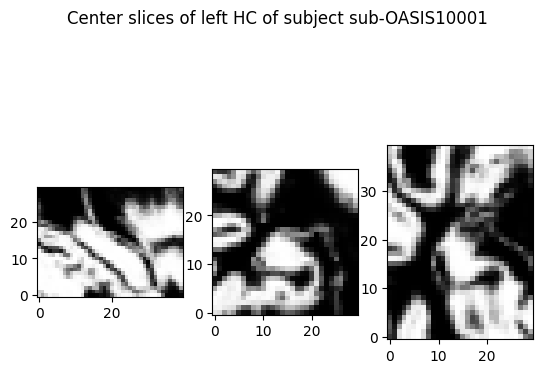

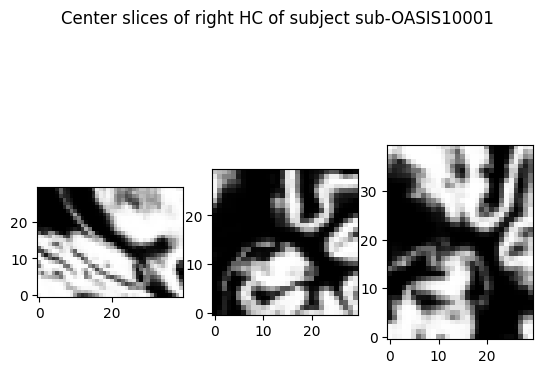

In [36]:
plot_hc(data_folder, 'sub-OASIS10001', "left", cut_coords=(15, 20, 15))
plot_hc(data_folder, 'sub-OASIS10001', "right", cut_coords=(15, 20, 15))

At this point, we want to re-train our model with this enlarged input dataset.

Given our setup, the only thing we need to do is to update our train and validation dataframes to encode the fact that we now have two samples per subject:

In [37]:
%%writefile -a prepare_train_validation_sets.py

import numpy as np

train_df = train_df.loc[np.repeat(train_df.index, 2)].reset_index(drop=True)
train_df["hemi"][::2] = "right"
valid_df = valid_df.loc[np.repeat(valid_df.index, 2)].reset_index(drop=True)
valid_df["hemi"][::2] = "right"

train_df.to_csv("train.csv")
valid_df.to_csv("validation.csv")

Appending to prepare_train_validation_sets.py


```{note}
Note that, for simplificity due to the constraints of the notebook format, we just appenned the previous code to the `prepare_train_validation_sets.py` file instead of modifying it, which would be much cleaner. Feel free to open the python file and replace the relevant portion of the code with the previous cell.
```

And... that's all we need to do. We can call `dvc repro` to run the full experiment with the new dataset:

In [38]:
! dvc repro

Verifying data sources in stage: 'data.dvc'                                     
  0% Committing data to cache|               |416/? [00:00<00:00, 3936.19file/s]
!
  0%|          |memory://.4Xf5pKGSumf9WaunfFt7Pr.tm0.00/? [00:00<?,        ?B/s]
  0%|          |memory://.4Xf5pKGSumf9WaunfFt7Pr0.00/188k [00:00<?,        ?B/s]
                                                                                
Running stage 'prepare_train_validation':                                       
> python prepare_train_validation_sets.py
**************************************************
Train dataset:
       N          age %sexF  education         MMS CDR=0 CDR=0.5 CDR=1 CDR=2
AD   58   77.4 ± 7.5  69.0  2.8 ± 1.4  22.6 ± 3.6     0      37    19     2
CN  242  43.4 ± 23.5  62.0  3.6 ± 1.2  29.8 ± 0.5    97       0     0     0

**************************************************
Validation dataset:
      N          age %sexF  education         MMS CDR=0 CDR=0.5 CDR=1 CDR=2
AD  15   78.2 ± 6.6  40.0  

In [38]:
!git status

On branch main
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   data.dvc
	modified:   dvc.lock
	modified:   prepare_train_validation_sets.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	metrics.json
	params.yaml

no changes added to commit (use "git add" and/or "git commit -a")


In [39]:
! git add data.dvc dvc.lock prepare_train_validation_sets.py

In [40]:
! git commit -m "Second model, trained with images cropped around left and right HC"
! git tag -a "v2.0" -m "model v2.0, left and right HC"

[main 964513d] Second model, trained with images cropped around left and right HC
 3 files changed, 33 insertions(+), 23 deletions(-)


In [41]:
! git log

commit 964513d67283283bd27fb9e25526ceaed87978c5 (HEAD -> main, tag: v2.0)
Author: John Doe <john.doe@inria.fr>
Date:   Mon Nov 13 15:47:42 2023 +0100

    Second model, trained with images cropped around left and right HC

commit 1c34f1bb812122c208a8d7901ce0bbde8e159ae4 (tag: v1.0)
Author: John Doe <john.doe@inria.fr>
Date:   Mon Nov 13 15:42:27 2023 +0100

    First model, trained with images cropped around left HC

commit 577887bd9f51ac35efacdefe35d03013c835f437
Author: John Doe <john.doe@inria.fr>
Date:   Mon Nov 13 15:38:47 2023 +0100

    initialize DVC


## Reproducing

Similarly as in chapter 1, imagine that we have to go back to the first version of our experiment. As we saw in chapter 1, we can restore the state of the project with the `checkout` commands:

In [42]:
! git checkout v1.0
! dvc checkout

Note: switching to 'v1.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 1c34f1b First model, trained with images cropped around left HC
Building workspace index                            |2.92k [00:00, 5.10kentry/s]
Comparing indexes                                   |2.92k [00:02, 1.33kentry/s]
Applying changes                                      |4.00 [00:00,   131file/s]
M       model.h5
M       notes.txt
M       validation.csv
M       train.csv
M       data/


Now, we are going to see the benefits of having defined our experiment with DVC. If we check the status, DVC tells us that there is a change in the `run_experiment` stage:

In [43]:
! dvc status

run_experiment:                                                                 
	changed outs:
		modified:           metrics.json


And, if we run `dvc repro`, DVC is clever enough to know which stages to run given the dependencies that were modified. In addition, since we didn't modify anything besides going back to version 1 of the experiment, DVC does not re-run the `run_experiment` stage, it uses its cache to instantaneously restore the expeiments results:

In [44]:
! dvc repro

'data.dvc' didn't change, skipping                                              
Stage 'prepare_train_validation' didn't change, skipping                        
Stage 'run_experiment' is cached - skipping run, checking out outputs           
Use `dvc push` to send your updates to remote storage.                          


We can verify that our human-readable notes correspond to the experiment we are currently running (300 samples with learning rate of 0.0001):

In [45]:
! cat notes.txt

CNN model fitted on 300 samples with hyperparameters:
- learning rate = 0.0001
- number of epochs = 30
- size of batch = 4


Now, let's imagine we want to experiment the first version of our model with a different learning rate. All we need to do is to open the `params.yaml` file and update the parameter to the desired value.

Let's try increasing it to `10^3`:

In [46]:
%%writefile params.yaml

train:
    learning_rate: 0.001
    n_epochs: 30
    batch_size: 4

Overwriting params.yaml


In [47]:
! dvc repro

'data.dvc' didn't change, skipping                                              
Stage 'prepare_train_validation' didn't change, skipping                        
Running stage 'run_experiment':                                                 
> python run_experiment.py
**************************************************                    core>
Fitting model on 300 samples...
Epoch 0: loss = 0.2607, balanced accuracy = 0.6662
Epoch 1: loss = 0.1911, balanced accuracy = 0.7811
Epoch 2: loss = 0.2488, balanced accuracy = 0.9170
Epoch 3: loss = 0.2905, balanced accuracy = 0.9108
Epoch 4: loss = 0.1366, balanced accuracy = 0.9018
Epoch 5: loss = 0.1315, balanced accuracy = 0.9683
Epoch 6: loss = 0.1165, balanced accuracy = 0.8928
Epoch 7: loss = 0.1332, balanced accuracy = 0.8148
Epoch 8: loss = 0.1048, balanced accuracy = 0.8276
Epoch 9: loss = 0.2403, balanced accuracy = 0.9277
Epoch 10: loss = 0.1262, balanced accuracy = 0.8103
Epoch 11: loss = 0.0530, balanced accuracy = 0.9635
Epoch 12

In this case, DVC knows it has to re-run the `run_experiment` stage because there is no results cached which match the new set of dependencies.

We can again look at the notes to see that the learning rate has been changed to the new desired value:

In [48]:
!cat notes.txt

CNN model fitted on 300 samples with hyperparameters:
- learning rate = 0.001
- number of epochs = 30
- size of batch = 4


Cleaning:

In [25]:
# Do not run this unless you want to start over from scratch...
! rm model.*
! rm -rf .git
! rm -rf .dvc
! rm .gitignore
! rm .dvcignore
! rm metrics.json
! rm data.dvc
! rm -r data
! rm run_experiment.py prepare_train_validation_sets.py
! rm dvc.*
! rm train.csv validation.csv
! rm notes.txt
! rm params.yaml

zsh:1: no matches found: model.*
rm: metrics.json: No such file or directory
rm: notes.txt: No such file or directory
rm: params.yaml: No such file or directory
